# Exploratory Data Analysis

## Introduction<a id='Introduction'></a>

This notebook will be doing Exploratory Analysis the data from https://ridesdatabase.org/saferparks/data/ for the 2018 NEISS Analysis that includes data from 2013-2017 for injuries sustained from different theme park rides.

The Data Dictionary comes from the original website: https://www.cpsc.gov/Research--Statistics/NEISS-Injury-Data

## Table of Contents<a id='Table_of_Contents'></a>
  * [Introduction](#Introduction)
  * [Table of Contents](#Table_of_Contents)
  * [Imports](#Imports)
  * [Data Dictionary](#Data_Dictionary)
  * [Overview of Data](#Overview_of_Data)
  * [Pairplot](#Pairplots)
  * [Descriptive Statistics and Correlation](#Descriptive_Statistics_and_Correlation)
  * [Countplots](#Countplots)
  * [Data Over Time](#Data_Over_Time)
  * [Categorical Plots](#Categorical_Plots)
  * [Conclusion](#Conclusion)

## Imports<a id='Imports'></a>

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

#Don't display future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()


First, import the dataset. This was cleaned in notebook Capstone 2 - Data Wrangling.ipynb.

In [2]:
#Import cleaned data
data = pd.read_csv('data/clean_data/clean_data.csv')

Import the data dictionary for all the terms to get their definitions. 

In [3]:
dictionary = pd.read_csv('data/DataDictionary.csv')

## Data Dictionary<a id='Data_Dictionary'></a>

Let's format the Dictionary and view it to see all the terms and descriptions. 

In [4]:
dictionary.dropna(inplace=True)
dictionary.set_index('Excel/Tab Variable', inplace=True)

#drop Fire Involvement from dictionary since that is not in the dataset
dictionary.drop(index='Fire_Involvement', inplace=True) 

#drop Product_2t from dictionary since that is not in the dataset
dictionary.drop(index='Product_2', inplace=True)

In [5]:
dictionary

,SAS Variable,Description/Code book
Excel/Tab Variable,,
CPSC_Case_Number,NEK,CPSC case number
Treatment_Date,Trmt_date,Date of Treatment
Age,Age,Age of Patient
Sex,Sex,Sex of Patient
Race,Race,Race of Patient
Other_Race,Raceoth,Description of Other Race (Used with Race=3)
Body_Part,Bdpt,Injured Body Part
Diagnosis,Diag,Injury Diagnosis
Other_Diagnosis,Diagoth,Description of Other Diagnosis (Used with Diag...


Some things to note with some of the terms:

1. Product_1 corresponds to the **ProductCode** column where the values are as follows:

        1293 - amusement devices

        3295 - water slides, public

        3259 - go-karts

    I will be updating these values to the actual terms so it is easier to follow along with what they correspond to. 


2. After some research, it is not clear what the **Stratum**, **PSU** and **Weight** fields actually correspond to. They will be kept in this analysis in case the machine learning model sees any value in them. However, for our purposes, there will not be any in depth analysis with those fields. 

## Overview of Data<a id='Overview_of_Data'></a>

Let's review the datatypes of the dataset. 

In [6]:
#Update the data type to Strings for Product Code as they are categories, not ints. 
data['ProductCode'] = data['ProductCode'].values.astype('str')

#product codes: 1293 (amusement devices), 3295 (water slides, public), and 3259 (go-karts).
#Update the product codes values to align with their actual meaning. 

#Create a dictionary for the product codes
product_codes = {'1293':'amusement devices (1293)', '3295': 'water slides, public (3295)', '3259':'go-karts (3259)'}

#Update the product code to the proper strings
data.replace(product_codes, inplace=True)

#View data types to make sure everything seems correct. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6584 entries, 0 to 6583
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Treatment_Date    6584 non-null   object 
 1   Age               6584 non-null   int64  
 2   Sex               6584 non-null   object 
 3   Narrative         6584 non-null   object 
 4   Diagnosis         6584 non-null   object 
 5   Other_Diagnosis   986 non-null    object 
 6   BodyPart          6584 non-null   object 
 7   Disposition       6584 non-null   object 
 8   ProductCode       6584 non-null   object 
 9   Device_category   6584 non-null   object 
 10  Device_type       6584 non-null   object 
 11  Location          6584 non-null   object 
 12  Stratum           6584 non-null   object 
 13  PSU               6584 non-null   int64  
 14  Weight            6584 non-null   float64
 15  CPSC_Case_Number  6584 non-null   int64  
dtypes: float64(1), int64(3), object(12)
memory

We see that most of the columns are objects which means they are categorical data. Only Age, PSU, Weight, and CPSC_Case_Number are numerical data. 

Let's review what the dataset looks like. 

In [7]:
#View the data
data.sample(5)

,Treatment_Date,Age,Sex,Narrative,Diagnosis,Other_Diagnosis,BodyPart,Disposition,ProductCode,Device_category,Device_type,Location,Stratum,PSU,Weight,CPSC_Case_Number
6463,3/13/2013,20,M,20YO HISP MALE AT A GO CART TRACK TODAY DRIVIN...,Fracture,NaN,Finger,Treated and released,go-karts (3259),Go karts,go kart,Sports/recreation,V,91,14.8537,130337563
1349,2/5/2017,8,F,8YOF PLAYING IN BOUNCE HOUSE; DX STRAINED LO...,"Strain, sprain",NaN,"Trunk, lower",Treated and released,amusement devices (1293),Inflatables,inflatable,Unknown,C,20,4.7570,170221110
5344,2/11/2014,16,M,16YOM STRAINED KNEE ON AN AMUSEMENT PARK RIDE ...,"Strain, sprain",NaN,Knee,Treated and released,amusement devices (1293),Amusement rides,amusement ride,Sports/recreation,M,63,81.5760,140232145
1746,9/14/2016,47,M,47 YO M RACING IN GO-CART FELL OUT INJURED NEC...,"Strain, sprain",NaN,Neck,Treated and released,go-karts (3259),Go karts,go kart,Unknown,V,17,15.3480,160941797
6190,6/3/2013,15,M,15 YOM LIFTED A GO-CART AT HIS GRANDFATHERS HO...,"Strain, sprain",NaN,"Trunk, upper",Treated and released,go-karts (3259),Not identified or unrelated,go kart - home or street,Home,L,42,77.2173,130616857


Some things to note, we see that the Narrative field appears to be short descriptions of what happened that caused the injury. While that is useful information on a case by case basis, it appears that a majority of the important data has already been split out into the separate columns. As a result, we won't be using this field much in analysis. 

We also see that there are some mising values in the Other_Diagnosis column, but we found in the previous data cleaning notebook that these missing values correspond to the "Other" field in Diagnosis. Most likley, this is reserved for uncommon Diagnosis and was a way to limit how many categories were in the Diagnosis column.

Now let's run a pairplot to see if there are any trends in our data. 

## Pairplot<a id='Pairplots'></a>

Let's look at a pairplot of the data with the data colored for the Sex of the person that was injured. 

<Figure size 640x480 with 0 Axes>

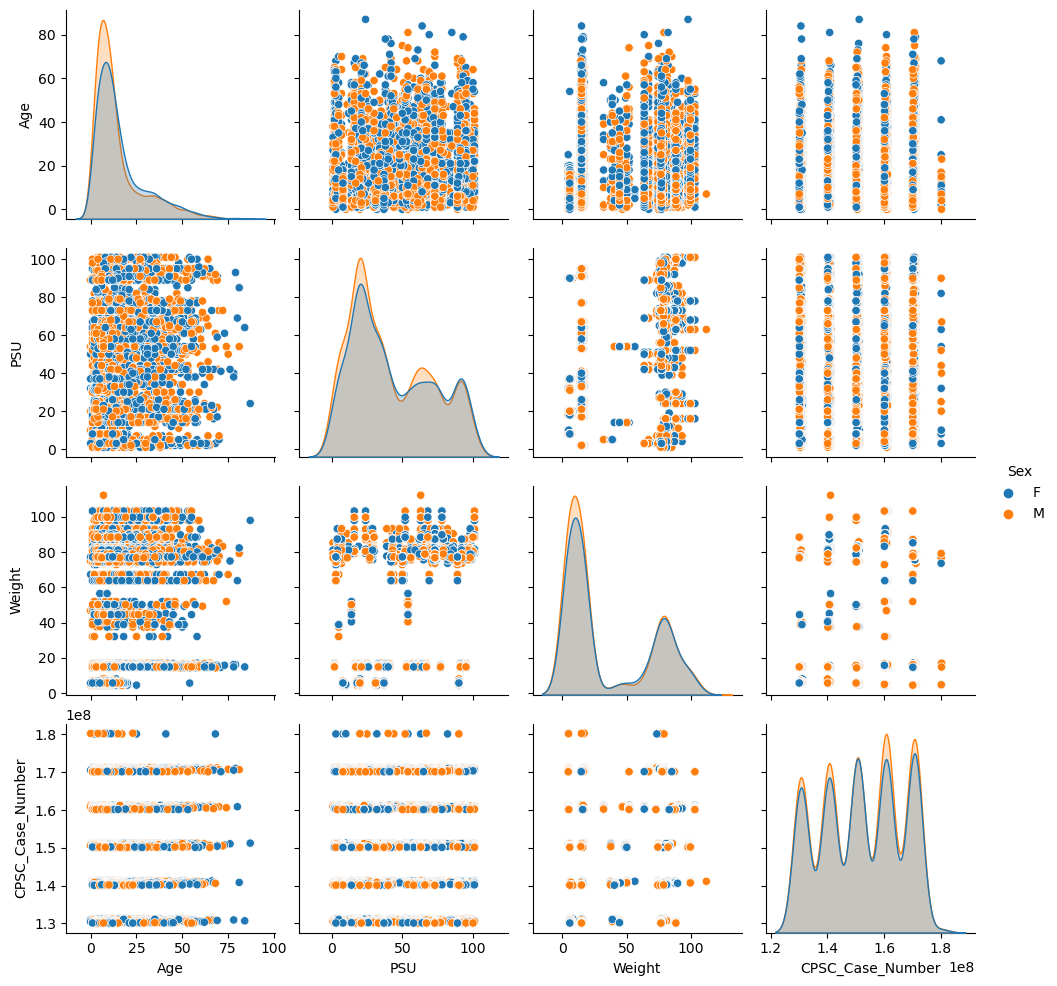

In [8]:
#Create a pairplot for continous variables. 
plt.clf()
sns.reset_defaults()
sns.pairplot(data, hue='Sex')
plt.show()

It looks like there are not any major trends in the data. We see a slight increase in Males as opposed to Females at the peak of the histogram in the top left box. However, it is not clear if that is just the difference in the higher amount of Males in the data. 

## Descriptive Statistics and Correlation<a id='Descriptive_Statistics_and_Correlation'></a>

In [9]:
#ECDF Function
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / n
    
    return x,y

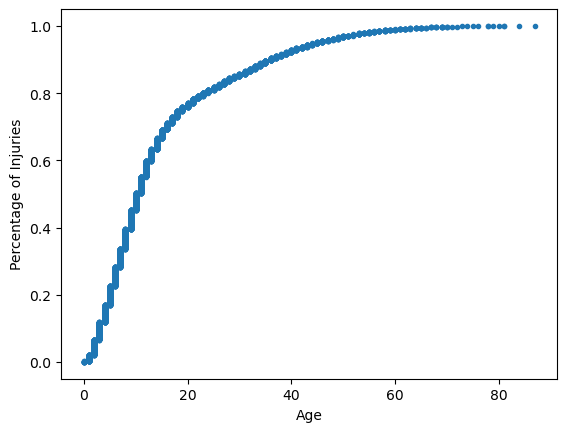

In [10]:
#Plot ECDF for Age. 
plt.clf()
x, y = ecdf(data['Age'])

_ = plt.plot(x, y, marker = '.', linestyle='none')
_ = plt.xlabel('Age')
_ = plt.ylabel('Percentage of Injuries')
plt.show()

Majority of injuries (around 80%) occur for people 20 and under. This matches what we saw in the above pairplots. Now lets get some statistics for all the Ages. 

In [11]:
data['Age'].describe()

count    6584.000000
mean       15.090067
std        13.614401
min         0.000000
25%         6.000000
50%        10.000000
75%        19.000000
max        87.000000
Name: Age, dtype: float64

The mean of the ages of the injuries is just over 15 years old, and the interquartile range is between 6 and 19.

<Figure size 640x480 with 0 Axes>

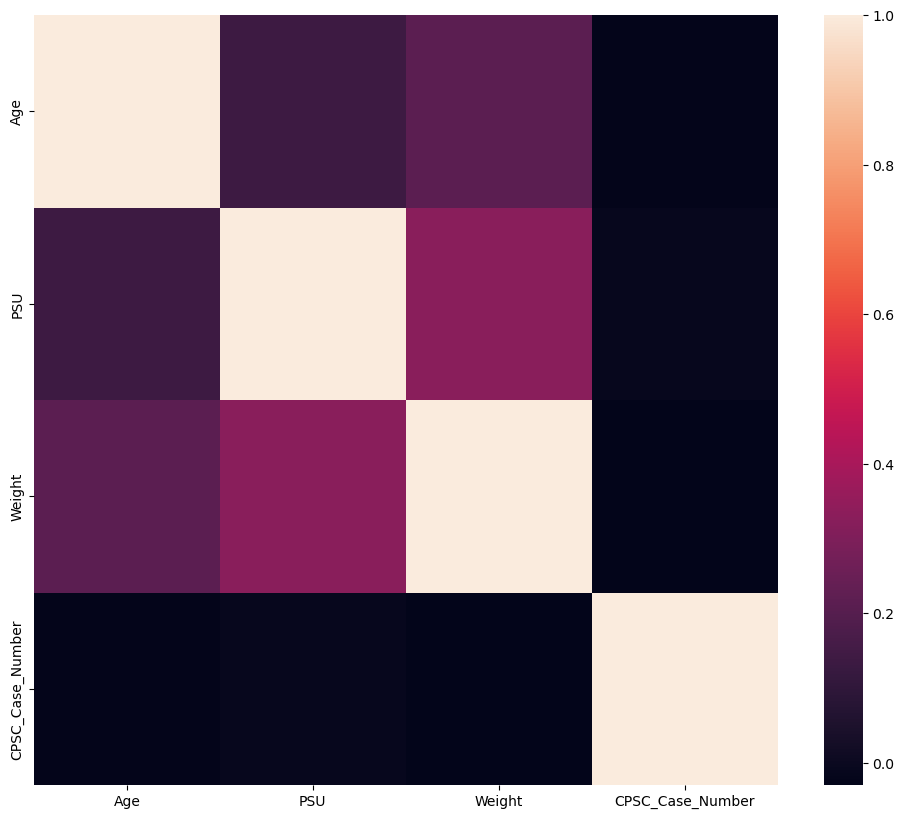

In [12]:
plt.clf()
plt.subplots(figsize=(12,10))
sns.heatmap(data.corr())
plt.show()

None of the continuous variables seem to be correlated to each other, which also confirms what we were seeing on the pairplots above. Now let's take a look at the categorical data.

In [13]:
data.describe(include='object')

,Treatment_Date,Sex,Narrative,Diagnosis,Other_Diagnosis,BodyPart,Disposition,ProductCode,Device_category,Device_type,Location,Stratum
count,6584,6584,6584,6584,986,6584,6584,6584,6584,6584,6584,6584
unique,1600,2,6582,27,240,25,6,3,5,55,7,5
top,5/29/2016,M,5YOF JUMPING IN A BOUNCE HOUSE AND STRAINED ANKLE,"Strain, sprain",PAIN,Head,Treated and released,amusement devices (1293),Inflatables,inflatable,Sports/recreation,C
freq,18,3401,2,1391,328,1004,6204,4476,2189,1993,3717,2214


We see here that Narrative has almost all unique fields which won't be helpful to analyze for our purposes. We also see the top values in each of the columns as well as how often they show up. 

## Countplots<a id='Countplots'></a>

Let's look at some countplots of the data. We can start with the distribution of Males vs Females. 

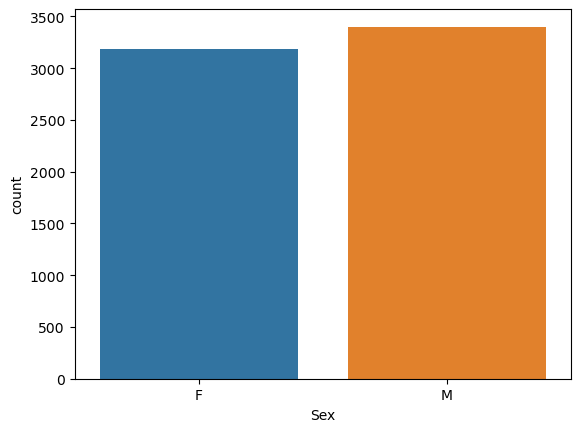

In [14]:
# Sex Count
#Pretty even distribution of males vs females with a slight majority to the males. 

sns.countplot(x='Sex', data= data)
plt.show()

We had seen in the pariplot above for Sex where there was a higher peak with the Males as opposed to the Females. This countplot confirms that there is a slight majority for Males in the data. 

We can also look at the count of each person's age.

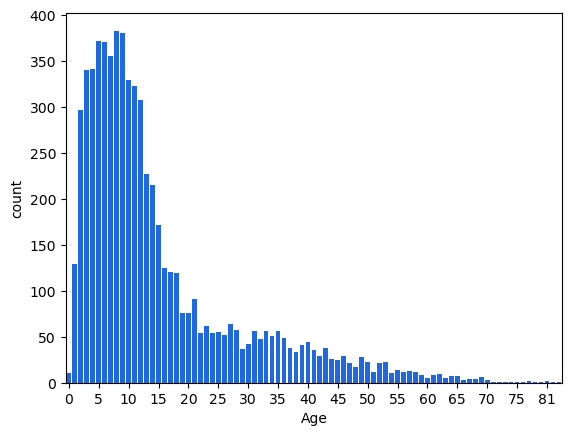

In [15]:
#Age Count
colors = ["#0060FF"]

sns.countplot(x='Age', data= data, palette = colors)
plt.xticks(ticks = np.arange(0, 85, step=5))
plt.show()

A majority of the injuries are occuring in people under the age of 20. This confirms what the ECDF found previously. Now let's look at all the Diagnosis counts. 

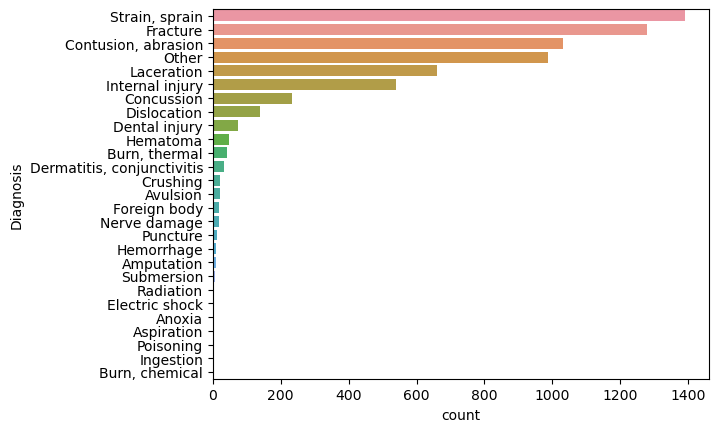

In [16]:
# Diganosis Count

sns.countplot(y='Diagnosis', data= data, order = data['Diagnosis'].value_counts().index)
plt.show()

Strains/Sprains, Fractures, and Contusions are the most common Diagnosis of injuries.

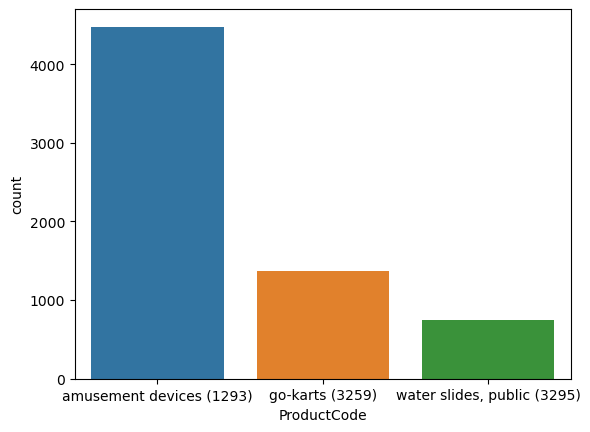

In [17]:
#Product Code Count
#product codes: 1293 (amusement devices), 3295 (water slides, public), and 3259 (go-karts).

sns.countplot(x='ProductCode', data= data)
plt.show()

Amusement devices have over 2/3 of the injury data in regards to Product codes. 

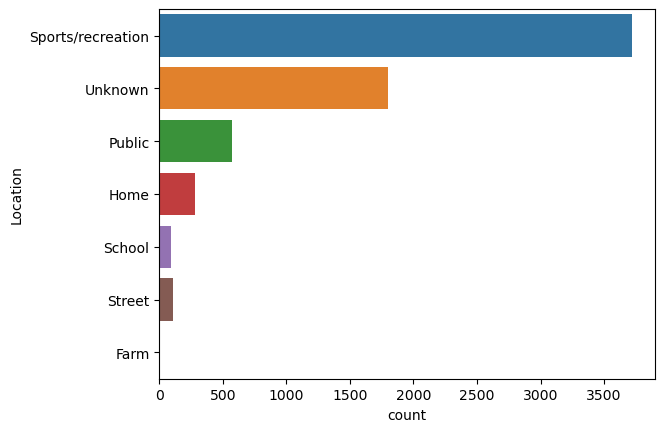

In [18]:
#Location Count. 

sns.countplot(y='Location', data= data)
plt.show()

Sports/Recreation is the most common place. However, there are also a lot of unknown. 

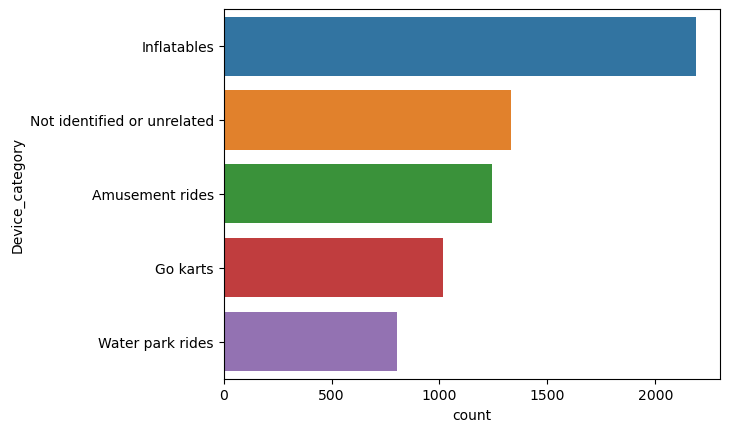

In [19]:
#Device Category Count. 

sns.countplot(y='Device_category', data= data, order = data['Device_category'].value_counts().index)
plt.show()

Inflatables seems to be the most common injury type. There are a lot of unidentified ones as well. 

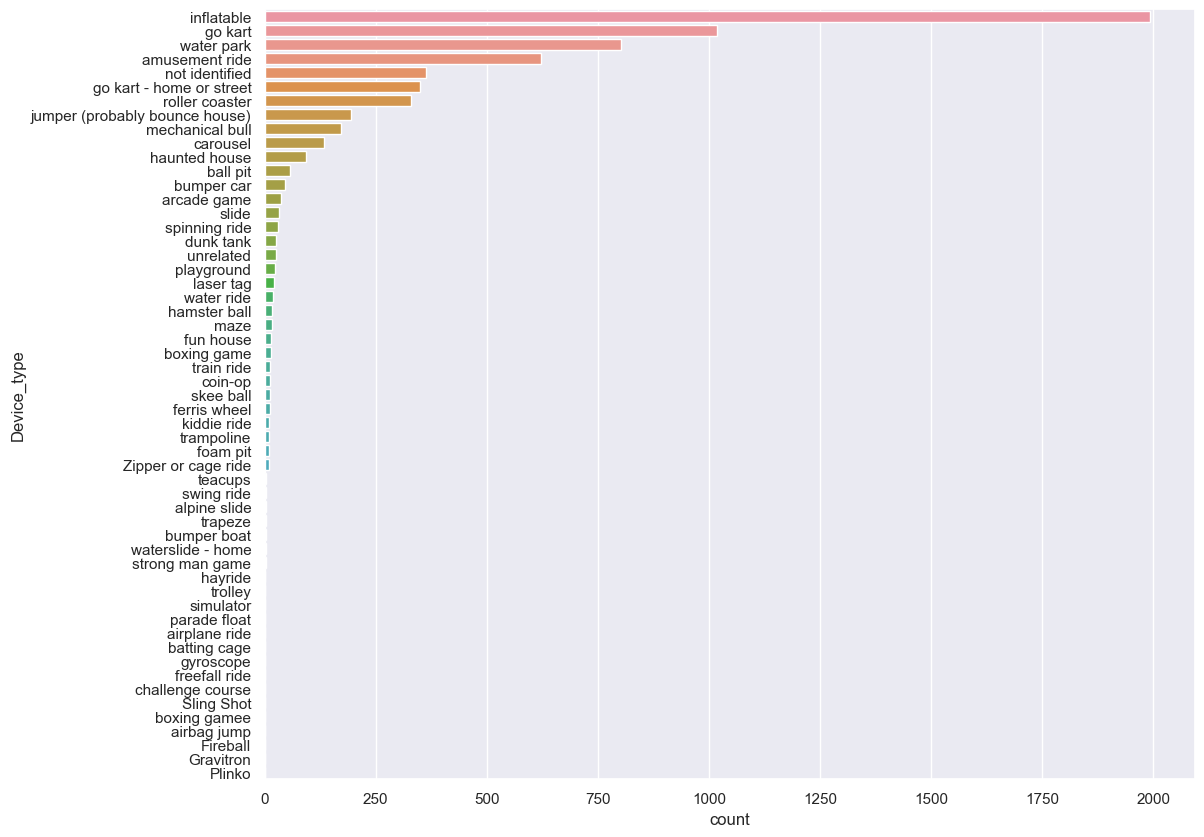

In [20]:
sns.set(rc={'figure.figsize':(12,10)})
sns.countplot(y='Device_type', data= data, order = data['Device_type'].value_counts().index)
plt.show()

Inflatables seem to be the most common device that an injury occurs on. Second would be go karts. 

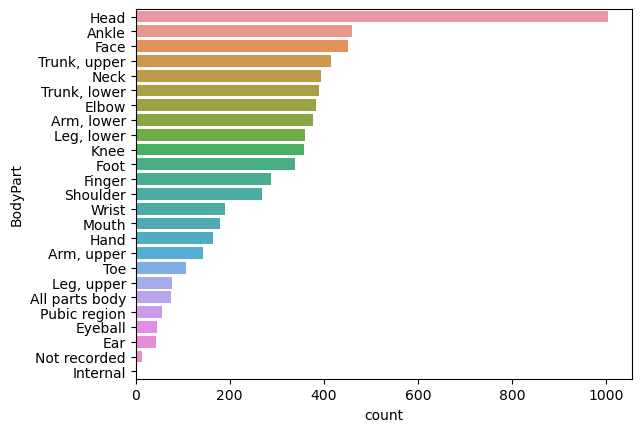

In [21]:
sns.reset_defaults()
sns.countplot(y='BodyPart', data= data, order = data['BodyPart'].value_counts().index)
plt.show()

Head Injuries are the most common. The top 3 and 4 out of the top 5 are to the head/neck area. 

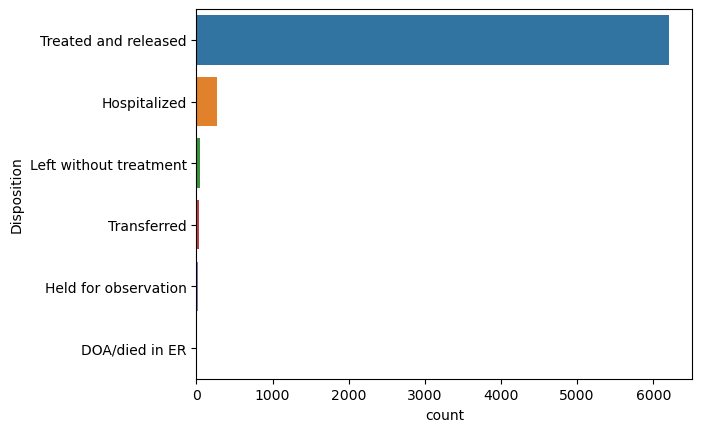

In [22]:
sns.countplot(y='Disposition', data= data, order = data['Disposition'].value_counts().index)
plt.show()

A majority of the injuries appear to be minor.

## Data Over Time<a id='Data_Over_Time'></a>

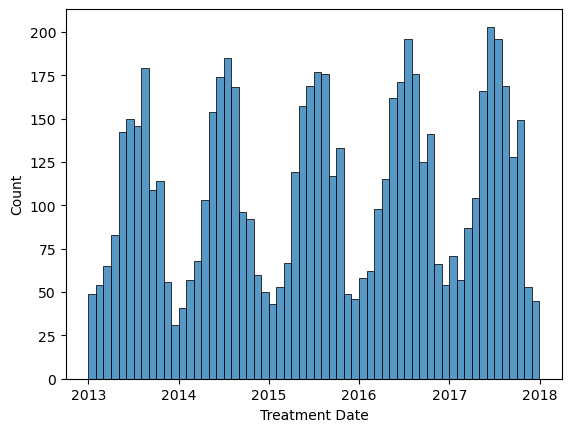

In [23]:
#Convert to Date Time Object
data['Treatment_Date'] = pd.to_datetime(data['Treatment_Date'])

sns.histplot(x='Treatment_Date', data= data, bins = 60)
plt.xlabel('Treatment Date')
plt.show()

This histogram shows that the majority of treatments occur in the months of May-Oct (5-10) each year. This makes sense since it would be the summer months and it is when kids are out of school and doing family vactions. 

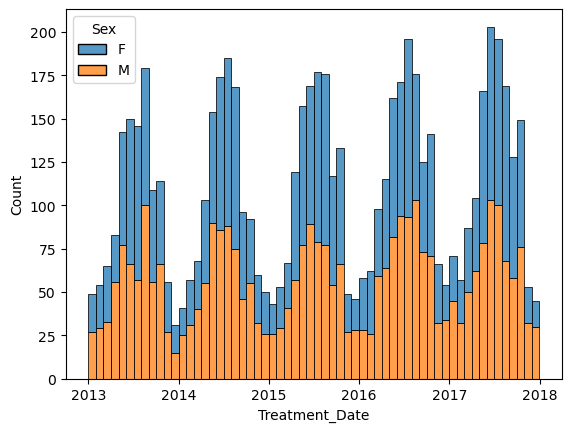

In [24]:
plt.clf()
sns.histplot(x='Treatment_Date', data= data, bins = 60, hue='Sex',multiple="stack")
plt.show()

With Males vs Females over time, we don't see any major trends, just the slight majority of males for most of the data. 

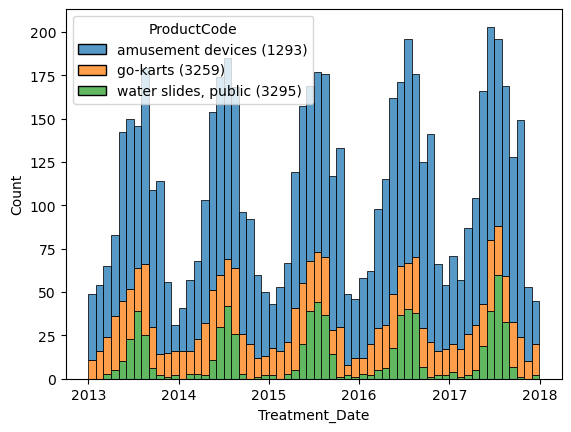

In [25]:
plt.clf()
sns.histplot(x='Treatment_Date', data= data, bins = 60, hue='ProductCode',multiple="stack")
plt.show()

Not seeing any specific trends in regrads to time for the Product codes. They loosely follow the similar patterns of hightening in the Summer months. 

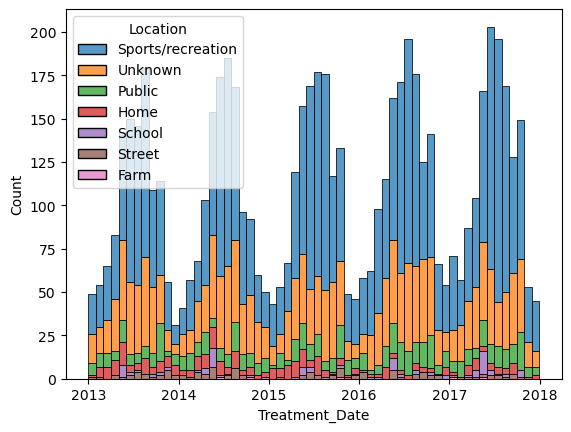

In [26]:
plt.clf()
sns.histplot(x='Treatment_Date', data= data, bins = 60, hue='Location',multiple="stack")
plt.show()

Not seeing any specific trends for the Location either when it comes to time. 

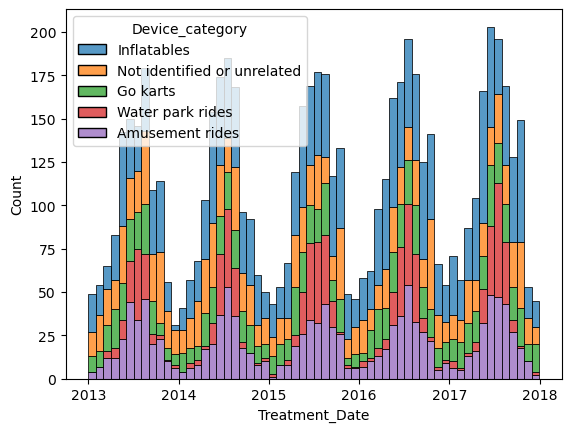

In [27]:
plt.clf()
sns.histplot(x='Treatment_Date', data= data, bins = 60, hue='Device_category',multiple="stack")
plt.show()

Inflatables have the highest but we do see the Water park rides overtake the Inflatables in the summer months which would also corresponds to the peaks we see for the seasonality of the data. 

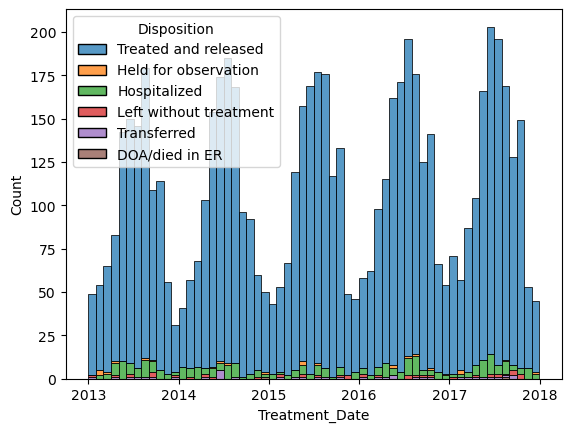

In [28]:
plt.clf()
sns.histplot(x='Treatment_Date', data= data, bins = 60, hue='Disposition',multiple="stack")
plt.show()

With a majority of the dataset falling into the Treated and released category, it's no surprise that is by far the highest compared to everything else. This also follows the summer trend. Let's see what the graph looks like when Treated and Released values are not included. 

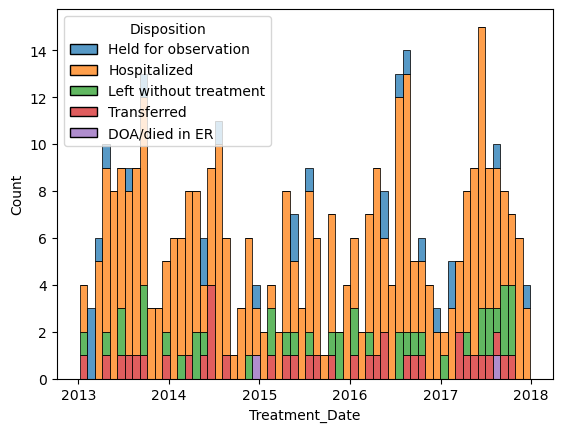

In [29]:
plt.clf()
filtered = data[data['Disposition'] != "Treated and released"]

sns.histplot(x='Treatment_Date', data= filtered, bins = 60, hue='Disposition',multiple="stack")
plt.show()

We still see seasonality, but now Hospitalized is the most common Disposition. Not seeing any specific trends from the data though. 

## Categorical Plots<a id='Categorical_Plots'></a>

Here we can explore the different relationships between all the categorical data. 

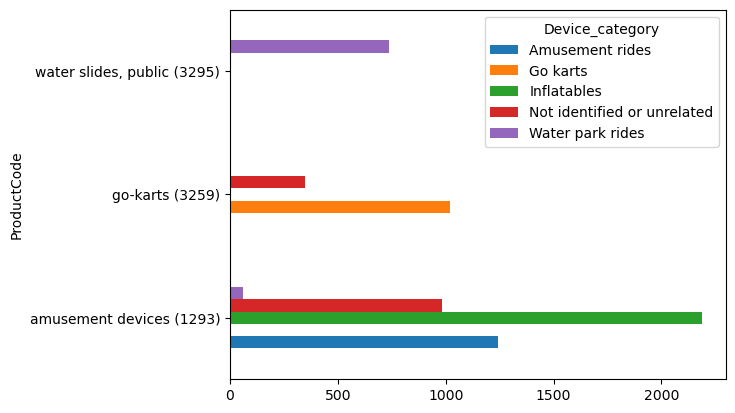

In [30]:
CrosstabResult=pd.crosstab(index=data['ProductCode'],columns=data['Device_category'])
CrosstabResult.plot.barh()

plt.show()

With Product Code and Device Category, we see that all inflatables and amusement rides are considered amusement devices, go-karts, match up 1-1, and water park rides can be either amusement devices or water slides,public. 

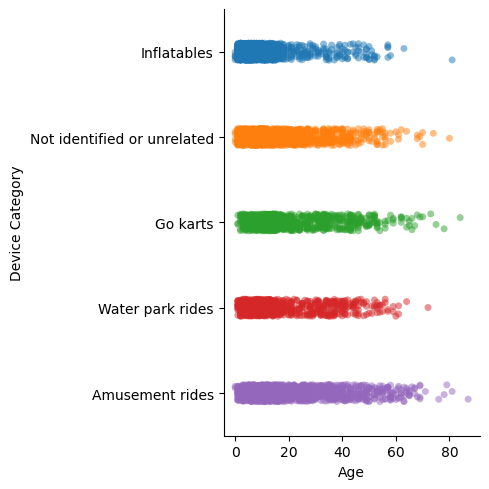

In [41]:
sns.catplot(x='Age', y='Device_category', data=data, alpha=.5)
plt.ylabel('Device Category')
plt.show()

For Age and Device Category, we see that everything is clustered in the younger ages, and then tails off the older the person is. However, Amusement rides seem to be clustered higher in age as well compared to the rest. 

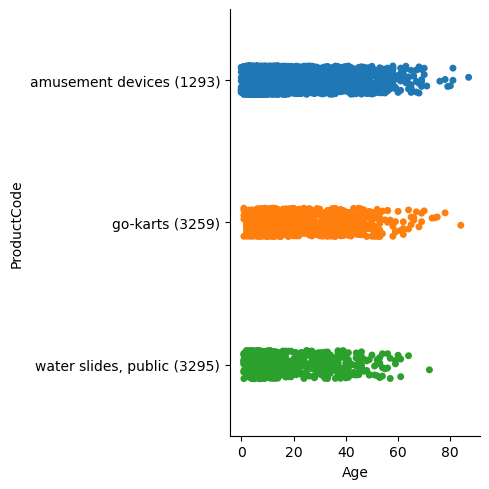

In [32]:
sns.catplot(x='Age', y='ProductCode', data=data)
plt.show()

We can see a similar trend where there is a high cluster at the young ages, and then it trails off with the older ages. Amusement deviecs has the highest cluster at the older ages. 

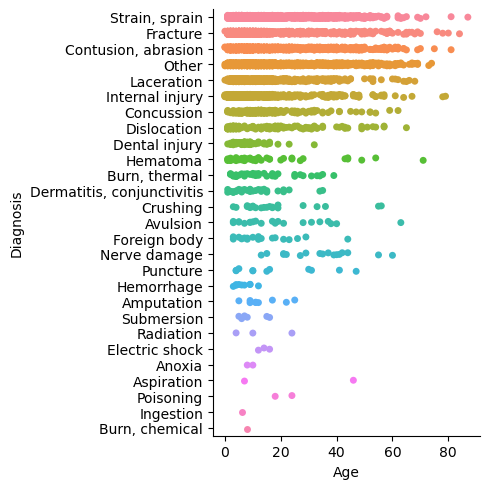

In [33]:
sns.catplot(x='Age', y='Diagnosis', data=data,order = data['Diagnosis'].value_counts().index)
plt.show()

When looking at the different diagnosis when compared to Age, we see that Sprains, Fractures, and Contusions are pretty common for all age groups. However, Dental Injuries seem to be skewed toward the younger demographic. 

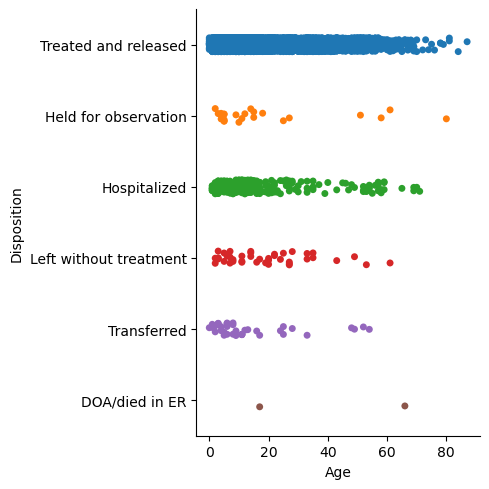

In [34]:
sns.catplot(x='Age', y='Disposition', data=data)
plt.show()

Treated and Released is representative of the majority of the dataset, but it's interesting to see how age affects the other ones. It looks like the Hospitalized Disposition has a large cluster in the 0-20 range which is where a majority of our data exists. The other dispositions look like they also slightly skew younger, but not as drastically. 

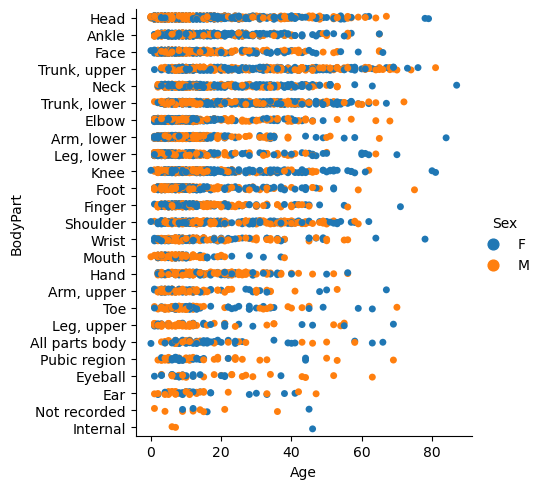

In [35]:
sns.catplot(x='Age', y='BodyPart', data=data, hue='Sex',order = data['BodyPart'].value_counts().index)
plt.show()

The most common injury is the head which skews younger. However, the 'Trunk,upper' body part looks like it affects a higher range of ages. No significant different between sexes. 

## Conclusion<a id='Conclusion'></a>

After reviewing the data points a bit further, we are seeing that most of the important data classifying the injuries are categorical apart from age. We see that slightly more males are affected than femailes, and a majority of the injuries happen to young people (under 20). Strains/Sprains, Fractures, and Contusions are the most common Diagnosis of injuries. Amusement Devices (Product Code) seem to be the cause of a majority of the injuries. Sports/Recreation is the most common Location. Inflatables are the most common Device Category and Device Type. Head injuries are the most common body part that is injured. A majority of the injuries appear to be minor as usually people are treated and released. We also see that a majority of the injuries occur in the summer months.  